In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
from torch import nn
from torch.utils.data import DataLoader
import random, time

# Variáveis

In [7]:
# Variáveis
X_DIM = 32
SPACE_DIM = 4
BATCH_SIZE = 32
EPOCHS = 300
DEBUG_STEPS = 30
LEARNING_RATE = 0.00002

# Criando um dataset
- Dataset fictício, de ondas senoidais onde cada linha do dataset é um vetor de **X_DIM** dimensões

dataset.shape=(10000, 32)


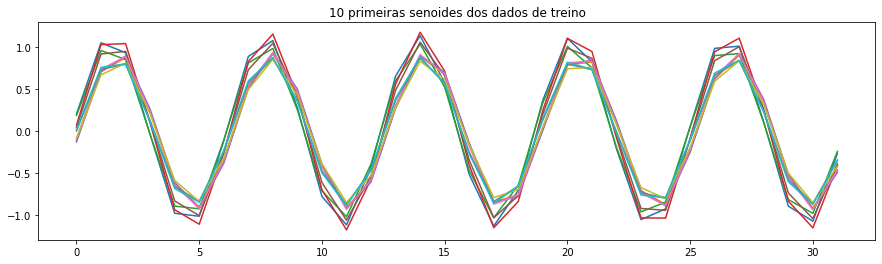

In [3]:
# Gerando um dataset senoidal de 10 pontos randomico
def create_dataset(n = 100_000):
    vetor = []
    for k in range(n):
        amp = random.randint(800, 1200)/1000
        x0 = random.randint(-10, 10)/50
        vetor.append(amp * np.sin(np.arange(X_DIM) + x0))
    
    return np.array(vetor)

n = 10_000
dataset = create_dataset(n)
print (f'{dataset.shape=}')

n_firsts = 10
plt.figure(figsize=(15, 4))
for k, linha in enumerate(dataset[:n_firsts]):
    plt.plot(linha)

plt.title(f'{n_firsts} primeiras senoides dos dados de treino')
plt.show()

# Transformando em tensor

In [4]:
VALOR_MAXIMO = dataset.max()

# Transformando o dataset em um tensor
dataset_tensor = torch.tensor(dataset / VALOR_MAXIMO, dtype=torch.float)
print (f'{dataset_tensor.shape=}, {dataset_tensor.min()=}, {dataset_tensor.max()=}')

dataloader = DataLoader(dataset_tensor, batch_size=BATCH_SIZE, shuffle=True)
x_batch = next(iter(dataloader))
print (f'{x_batch.shape=}')

dataset_tensor.shape=torch.Size([10000, 32]), dataset_tensor.min()=tensor(-1.0000), dataset_tensor.max()=tensor(1.)
x_batch.shape=torch.Size([32, 32])


# Criando modelos generator e discriminator

In [5]:
# Criando os modelos generator e Discriminator
def create_generator(n_output):
    return nn.Sequential(
        nn.Linear(in_features=SPACE_DIM, out_features=8),
        nn.ReLU(True),
        nn.Linear(in_features=8, out_features=16),
        nn.ReLU(True),
        nn.Linear(in_features=16, out_features=n_output),
        nn.Tanh()
    )

def create_discriminator(n_input):
    return nn.Sequential(
        nn.Linear(in_features=n_input, out_features=16),
        nn.LeakyReLU(negative_slope=0.2),
        nn.Linear(in_features=16, out_features=8),
        nn.LeakyReLU(negative_slope=0.2),
        nn.Linear(in_features=8, out_features=1),
        nn.Sigmoid()
    )

def create_noise(b_size_):
    return torch.randn((b_size_, SPACE_DIM))

generator = create_generator(X_DIM)
discriminator = create_discriminator(X_DIM)
noise = create_noise(5)
output_generator = generator(noise)
output_discriminator = discriminator(output_generator)

print (f'{noise.shape=}')
print (f'{output_generator.shape=}')
print (f'{output_discriminator.shape=}')

noise.shape=torch.Size([5, 4])
output_generator.shape=torch.Size([5, 32])
output_discriminator.shape=torch.Size([5, 1])


# Função útil para inicialização dos pesos

In [6]:
# Funções úteis
def weight_init(m):
    if (m.__class__.__name__ == 'Linear'):
        nn.init.normal_(m.weight.data, 0., 0.02)

def tensor_of_ones(b_size_):
    return torch.ones((b_size_, ), dtype=torch.float)

def tensor_of_zeros(b_size_):
    return torch.zeros((b_size_, ), dtype=torch.float)

# Treinamento

In [8]:
# Treinando
n = 1_000
dataset = create_dataset(n)
dataset_tensor = torch.tensor(dataset / dataset.max(), dtype=torch.float)
dataloader = DataLoader(dataset_tensor, batch_size=BATCH_SIZE, shuffle=True)

generator = create_generator(X_DIM)
discriminator = create_discriminator(X_DIM)
generator.apply(weight_init)
discriminator.apply(weight_init)

# Criando função perda e otimizadores
criterion = nn.BCELoss()

optim_discriminator = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(.5, .999))
optim_generator = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(.5, .999))

results = []
fixed_noise = create_noise(5)

fixed_noise_one = create_noise(1)
fixed_noise_history = [] # este vetor guarda a "história" de um fixed_noise de uma linha somente, gerado a cada época, para ver sua evolução.

cabecalho = ['epoch', 'd_real_loss', 'd_fake_loss', 'g_loss', 'time']
print ('|'.join([str(c).center(20) for c in cabecalho]))

for epoch in range(1, EPOCHS+1, 1):
    v_real_loss, v_fake_loss, v_g_loss = [], [], []
    inicio = time.time()
    with torch.set_grad_enabled(True):
        for real_data in dataloader:
            b_size = len(real_data)

            # Treinando o discriminator
            optim_discriminator.zero_grad()
            output_real = discriminator(real_data)
            loss_real = criterion(output_real.view(-1), tensor_of_ones(b_size))
            loss_real.backward()

            # Gerando noise
            noise = create_noise(b_size)
            fake_data = generator(noise)
            
            output_fake = discriminator(fake_data.detach())
            loss_fake = criterion(output_fake.view(-1), tensor_of_zeros(b_size))
            loss_fake.backward()

            optim_discriminator.step()

            # Treinando o generator
            optim_generator.zero_grad()
            output_gen = discriminator(fake_data)
            loss_gen = criterion(output_gen.view(-1), tensor_of_ones(b_size))
            loss_gen.backward()
            optim_generator.step()

            v_real_loss.append(loss_real.item())
            v_fake_loss.append(loss_fake.item())
            v_g_loss.append(loss_gen.item())
    
    with torch.no_grad():
        fake_img_one = generator(fixed_noise_one)
        fixed_noise_history.append(fake_img_one[0].detach().numpy())
    
    v_real_loss = np.array(v_real_loss).mean()
    v_fake_loss = np.array(v_fake_loss).mean()
    v_g_loss = np.array(v_g_loss).mean()
    tempo = time.time() - inicio

    vetor = [epoch, v_real_loss, v_fake_loss, v_g_loss, tempo]
    results.append(vetor)

    if (epoch % DEBUG_STEPS == 0):
        print ('|'.join([str(round(v,5)).center(20) for v in vetor]))

results = np.array(results)
fixed_noise_history = VALOR_MAXIMO * np.array(fixed_noise_history) # como se fosse o INV_TRANSFORM
# pois lá na preparação dos dados fizemos uma divisão pelo maximo para os dados ficarem entre -1 e 1
print ('fim treinamento')

       epoch        |    d_real_loss     |    d_fake_loss     |       g_loss       |        time        
         30         |      0.69844       |      0.67097       |      0.71583       |      0.06118       
         60         |      0.62565       |      0.69226       |      0.69404       |      0.06593       
         90         |      0.57123       |      0.75145       |      0.63807       |      0.06366       
        120         |      0.59611       |      0.76348       |      0.62754       |      0.06643       
        150         |      0.66698       |      0.72067       |      0.66643       |      0.05887       
        180         |      0.70537       |      0.68917       |      0.69718       |      0.06433       
        210         |      0.72393       |      0.66906       |      0.71785       |      0.06314       
        240         |      0.73853       |      0.65424       |      0.73365       |      0.06465       
        270         |      0.74075       |       0.651 

# Análises gráficas
- Perdas dos modelos discriminator (para fake_data e real_data) e generator
- No quarto gráfico temos uma comparação entre dados reais do dataset **(em verde)** e dados fakes **(em vermelho)**

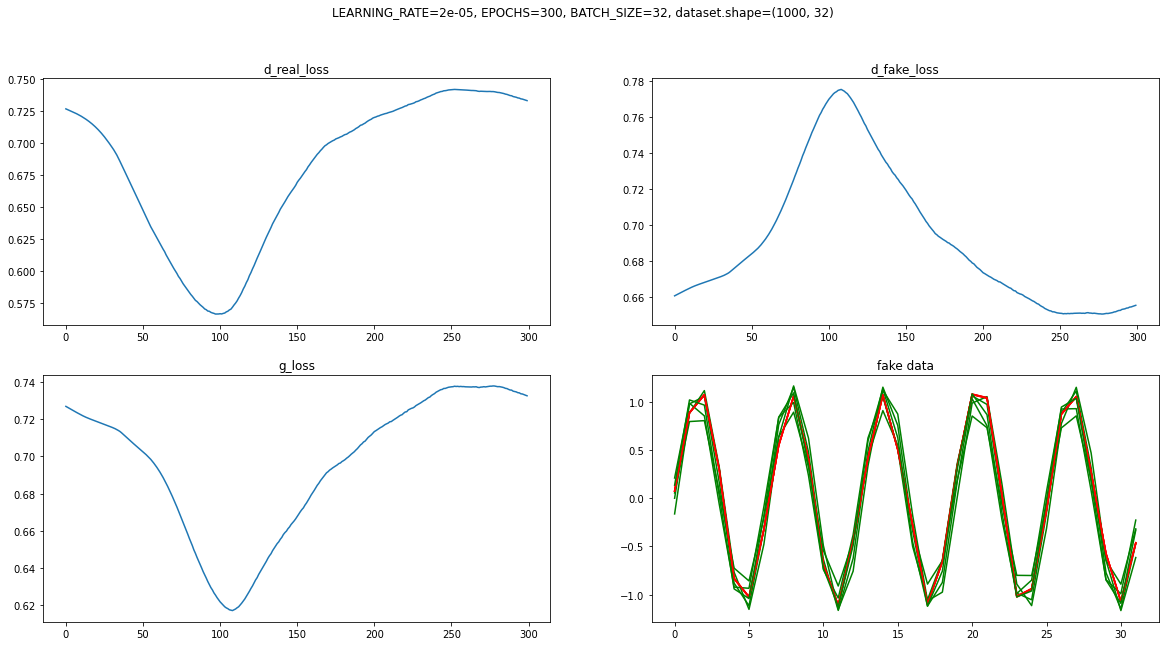

In [9]:
# Analisando
plt.figure(figsize=(20, 10))
for k, label in enumerate(cabecalho[1:-1]):
    plt.subplot(2, 2, k+1)
    plt.plot(results[:,k+1])
    plt.title(label)

fake_data = generator(fixed_noise)
fake_data = fake_data.detach().numpy()
for cada_linha in fake_data:
    plt.subplot(2, 2, 4)
    plt.plot(cada_linha*VALOR_MAXIMO, c='r')
    plt.plot(random.choice(dataset), c='g')
plt.title('fake data')

plt.suptitle(f'{LEARNING_RATE=}, {EPOCHS=}, {BATCH_SIZE=}, {dataset.shape=}')
plt.show()

# Animação
- Criando um **gif** da evolução de um fixed_noise ao longo das épocas

MovieWriter Pillow unavailable; using Pillow instead.


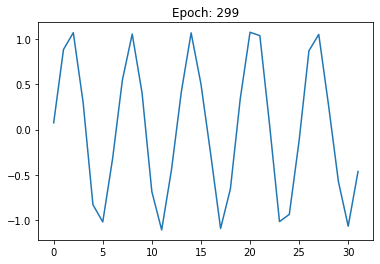

In [10]:
fig = plt.figure()
plt.rcParams['figure.autolayout'] = True
plt.xlim = (-20, 20)
plt.ylim = (-20, 50)
plt.plot(fixed_noise_history[0])

def animate(i):
    plt.clf()
    plt.title(f'Epoch: {i}')
    return plt.plot(fixed_noise_history[i])

anim = FuncAnimation(fig, animate, interval=100, frames=len(fixed_noise_history))
anim.save('epochs_results.gif', writer='Pillow')